In [2]:
# === 1) Grab a tiny validation subset WITH IMAGES ===
from datasets import load_dataset
from pathlib import Path
import json

OUT = Path("/home/jupyter-24251d5803/DocLayNet-mini")           # <-- change if you want
IMG_DIR = OUT / "PNG-1025" / "val"               # DeepDoctection expects this layout
COCO_DIR = OUT / "COCO"; COCO_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# 200 samples from validation (has 'image' column with PIL image)
ds = load_dataset("ds4sd/DocLayNet-v1.2", split="validation[:200]")

# === 2) Build a COCO json and save the images ===
categories = [
    {"id":1,"name":"CAPTION"}, {"id":2,"name":"FOOTNOTE"}, {"id":3,"name":"FORMULA"},
    {"id":4,"name":"LIST-ITEM"}, {"id":5,"name":"PAGE-FOOTER"}, {"id":6,"name":"PAGE-HEADER"},
    {"id":7,"name":"PICTURE"}, {"id":8,"name":"SECTION-HEADER"}, {"id":9,"name":"TABLE"},
    {"id":10,"name":"TEXT"}, {"id":11,"name":"TITLE"}
]

coco = {"images":[], "annotations":[], "categories":categories}
ann_id = 1
for i, ex in enumerate(ds):
    # save image
    pil = ex["image"]          # PIL.Image
    w, h = pil.size
    file_name = f"{ex['image_id']}.png"
    pil.save(IMG_DIR / file_name)

    # image entry
    coco["images"].append({
        "id": ex["image_id"],
        "file_name": file_name,
        "width": w, "height": h
    })

    # annotations (one per region)
    # ex["bboxes"] : [[x,y,w,h], ...]  (DocLayNet HF uses xywh)
    # ex["category_id"] : [int,...]
    for bbox, cid, area in zip(ex["bboxes"], ex["category_id"], ex["area"]):
        x, y, bw, bh = bbox
        coco["annotations"].append({
            "id": ann_id,
            "image_id": ex["image_id"],
            "category_id": int(cid),
            "bbox": [x, y, bw, bh],      # COCO expects xywh
            "area": float(area),
            "iscrowd": 0
        })
        ann_id += 1

with open(COCO_DIR / "val.json", "w") as f:
    json.dump(coco, f)

print("Saved:", COCO_DIR / "val.json")
print("Images in:", IMG_DIR)

# === 3) Evaluate with DeepDoctection ===
import deepdoctection as dd
from deepdoctection.eval import DetectionEvaluator
from ultralytics import YOLO

# Simple YOLO model (use any .pt; for a smoke test you can use a generic yolov8n.pt)
WEIGHTS = "/home/jupyter-24251d5803/.cache/deepdoctection/weights/yolo/yolov10x_best.pt"  # put your .pt here

# Minimal YOLO->DD adapter
def _yolo_to_detectresult(results, categories):
    outs=[]; id2name=categories.get_categories(as_dict=True)
    b=results.boxes
    if b is None or len(b)==0: return outs
    for i in range(len(b)):
        x1,y1,x2,y2 = b.xyxy[i].tolist()
        cls0 = int(b.cls[i].item()); score=float(b.conf[i].item())
        cid = cls0+1; cname=id2name.get(cid,"Unknown")
        outs.append(dd.DetectionResult(box=[x1,y1,x2,y2], score=score, class_id=cid, class_name=cname))
    return outs

class YoloDetector(dd.ObjectDetector):
    def __init__(self, conf,iou,weights,categories):
        self.name="yolo_detector"; self.model_id=self.get_model_id()
        from ultralytics import YOLO; self.model=YOLO(weights)
        self.conf=conf; self.iou=iou; self.categories=dd.ModelCategories(init_categories=categories)
    def predict(self, np_img):
        r=self.model(source=np_img, conf=self.conf, iou=self.iou, verbose=False)[0]
        return _yolo_to_detectresult(r, self.categories)
    def get_category_names(self): return self.categories.get_categories(as_dict=False)

DOCLAYNET_CATS = {i+1: getattr(dd.LayoutType, n.replace("-","_")) for i,n in enumerate(
    ["CAPTION","FOOTNOTE","FORMULA","LIST_ITEM","PAGE_FOOTER","PAGE_HEADER",
     "FIGURE","SECTION_HEADER","TABLE","TEXT","TITLE"])}

# Build a tiny analyzer that just uses our YOLO wrapper
from addict import Dict as AttrDict
def _build_local(cfg, mode="LAYOUT"):
    w = getattr(cfg.PT, mode).WEIGHTS
    if isinstance(w,str) and w.endswith(".pt"):
        return YoloDetector(0.25, 0.5, w, DOCLAYNET_CATS)
    return dd.ServiceFactory._build_layout_detector(cfg, mode)
dd.ServiceFactory.build_layout_detector = _build_local

analyzer = dd.get_dd_analyzer(config_overwrite=[
    f"PT.LAYOUT.WEIGHTS={WEIGHTS}",
    "USE_TABLE_SEGMENTATION=False",
    "USE_OCR=False"
])

# DeepDoctection expects this folder shape: OUT/{COCO,val.json} and OUT/PNG-1025/val/*.png
dataset = dd.DocLayNetDataset(data_path=str(OUT), splits="val")

preds = analyzer.analyze_dataset(dataset)
ev = DetectionEvaluator(dataset)
metrics = ev.eval(preds)
print(metrics)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

data/train-00000-of-00072.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

data/train-00001-of-00072.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

data/train-00002-of-00072.parquet:   0%|          | 0.00/525M [00:00<?, ?B/s]

data/train-00003-of-00072.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/train-00004-of-00072.parquet:   0%|          | 0.00/517M [00:00<?, ?B/s]

data/train-00005-of-00072.parquet:   0%|          | 0.00/517M [00:00<?, ?B/s]

data/train-00006-of-00072.parquet:   0%|          | 0.00/533M [00:00<?, ?B/s]

data/train-00007-of-00072.parquet:   0%|          | 0.00/544M [00:00<?, ?B/s]

data/train-00008-of-00072.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

data/train-00009-of-00072.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

data/train-00010-of-00072.parquet:   0%|          | 0.00/525M [00:00<?, ?B/s]

data/train-00011-of-00072.parquet:   0%|          | 0.00/566M [00:00<?, ?B/s]

data/train-00012-of-00072.parquet:   0%|          | 0.00/566M [00:00<?, ?B/s]

data/train-00013-of-00072.parquet:   0%|          | 0.00/533M [00:00<?, ?B/s]

data/train-00014-of-00072.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

data/train-00015-of-00072.parquet:   0%|          | 0.00/533M [00:00<?, ?B/s]

data/train-00016-of-00072.parquet:   0%|          | 0.00/553M [00:00<?, ?B/s]

data/train-00017-of-00072.parquet:   0%|          | 0.00/545M [00:00<?, ?B/s]

data/train-00018-of-00072.parquet:   0%|          | 0.00/545M [00:00<?, ?B/s]

data/train-00019-of-00072.parquet:   0%|          | 0.00/561M [00:00<?, ?B/s]

data/train-00020-of-00072.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

data/train-00021-of-00072.parquet:   0%|          | 0.00/325M [00:00<?, ?B/s]

data/train-00022-of-00072.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

data/train-00023-of-00072.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/train-00024-of-00072.parquet:   0%|          | 0.00/368M [00:00<?, ?B/s]

data/train-00025-of-00072.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/train-00026-of-00072.parquet:   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00027-of-00072.parquet:   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00028-of-00072.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/train-00029-of-00072.parquet:   0%|          | 0.00/597M [00:00<?, ?B/s]

data/train-00030-of-00072.parquet:   0%|          | 0.00/638M [00:00<?, ?B/s]

data/train-00031-of-00072.parquet:   0%|          | 0.00/625M [00:00<?, ?B/s]

data/train-00032-of-00072.parquet:   0%|          | 0.00/597M [00:00<?, ?B/s]

data/train-00033-of-00072.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00034-of-00072.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

data/train-00035-of-00072.parquet:   0%|          | 0.00/452M [00:00<?, ?B/s]

data/train-00036-of-00072.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

data/train-00037-of-00072.parquet:   0%|          | 0.00/703M [00:00<?, ?B/s]

data/train-00038-of-00072.parquet:   0%|          | 0.00/772M [00:00<?, ?B/s]

data/train-00039-of-00072.parquet:   0%|          | 0.00/739M [00:00<?, ?B/s]

data/train-00040-of-00072.parquet:   0%|          | 0.00/770M [00:00<?, ?B/s]

data/train-00041-of-00072.parquet:   0%|          | 0.00/754M [00:00<?, ?B/s]

data/train-00042-of-00072.parquet:   0%|          | 0.00/757M [00:00<?, ?B/s]

data/train-00043-of-00072.parquet:   0%|          | 0.00/583M [00:00<?, ?B/s]

data/train-00044-of-00072.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

data/train-00045-of-00072.parquet:   0%|          | 0.00/550M [00:00<?, ?B/s]

data/train-00046-of-00072.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/train-00047-of-00072.parquet:   0%|          | 0.00/382M [00:00<?, ?B/s]

data/train-00048-of-00072.parquet:   0%|          | 0.00/390M [00:00<?, ?B/s]

data/train-00049-of-00072.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

data/train-00050-of-00072.parquet:   0%|          | 0.00/382M [00:00<?, ?B/s]

data/train-00051-of-00072.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00052-of-00072.parquet:   0%|          | 0.00/390M [00:00<?, ?B/s]

data/train-00053-of-00072.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

data/train-00054-of-00072.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

data/train-00055-of-00072.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00056-of-00072.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/train-00057-of-00072.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

data/train-00058-of-00072.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

data/train-00059-of-00072.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

data/train-00060-of-00072.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

data/train-00061-of-00072.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00062-of-00072.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/train-00063-of-00072.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

data/train-00064-of-00072.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

data/train-00065-of-00072.parquet:   0%|          | 0.00/416M [00:00<?, ?B/s]

data/train-00066-of-00072.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

data/train-00067-of-00072.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/train-00068-of-00072.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

data/train-00069-of-00072.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

data/train-00070-of-00072.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

data/train-00071-of-00072.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/validation-00000-of-00007.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/validation-00001-of-00007.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

data/validation-00002-of-00007.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

data/validation-00003-of-00007.parquet:   0%|          | 0.00/572M [00:00<?, ?B/s]

data/validation-00004-of-00007.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

data/validation-00005-of-00007.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/validation-00006-of-00007.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

data/test-00000-of-00006.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

data/test-00001-of-00006.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

data/test-00002-of-00006.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

data/test-00003-of-00006.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/test-00004-of-00006.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

data/test-00005-of-00006.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/69375 [00:00<?, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [3]:
from pathlib import Path
OUT = Path("/home/jupyter-24251d5803/DocLayNet-mini")  # change if you like
(OUT / "PNG-1025" / "val").mkdir(parents=True, exist_ok=True)
(OUT / "COCO").mkdir(parents=True, exist_ok=True)
print("OUT =", OUT)

OUT = /home/jupyter-24251d5803/DocLayNet-mini


/home/jupyter-24251d5803/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
cuobjdump fatal   : Support for 'sm_2' has been removed. Please use CUDA toolkit (null) or earlier.
2025-10-24 19:31:17.563409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 19:31:21.424984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 19:31:35.972960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see 

ImportError: cannot import name 'ExternalJsonResourceRegistry' from 'deepdoctection.datasets.registry' (/home/jupyter-24251d5803/.local/lib/python3.10/site-packages/deepdoctection/datasets/registry.py)

In [5]:
import deepdoctection as dd
from datasets import load_dataset
from pathlib import Path
import json
import os
from tqdm import tqdm

# --- CONFIGURATION ---
# Define the output paths
OUT = Path("/home/jupyter-24251d5803/DocLayNet-mini")
IMG_DIR = OUT / "PNG-1025" / "val"
COCO_DIR = OUT / "COCO"
WEIGHTS = "/home/jupyter-24251d5803/.cache/deepdoctection/weights/yolo/yolov10x_best.pt" # Your model weights

# Ensure directories exist
IMG_DIR.mkdir(parents=True, exist_ok=True)
COCO_DIR.mkdir(parents=True, exist_ok=True)


# === 1) Grab a tiny validation subset WITH IMAGES using STREAMING ===
print("Loading dataset in STREAMING mode to avoid full download...")

# Re-using the streaming logic to ensure minimal download
try:
    # Try direct load with streaming
    ds_iterable = load_dataset(
        "ds4sd/DocLayNet-v1.2",
        split="validation",
        streaming=True
    )
    ds = ds_iterable.take(200)

except Exception as e:
    # Fallback to generic Parquet streaming if the script failed
    print(f"Streaming failed with direct name (Error: {e}). Trying generic Parquet streaming...")

    REPO_NAME = "ds4sd/DocLayNet-v1.2"
    SPLIT_FILE = "validation.parquet" # Typical Parquet file name
    data_files_map = {"validation": f"hf://datasets/{REPO_NAME}/validation/{SPLIT_FILE}"}

    ds_iterable = load_dataset(
        "parquet",
        data_files=data_files_map,
        split="validation",
        streaming=True
    )
    ds = ds_iterable.take(200)

print(f"Streaming activated. Processing 200 examples...")


# === 2) Build a COCO json and save the images ===
categories = [
    {"id":1,"name":"CAPTION"}, {"id":2,"name":"FOOTNOTE"}, {"id":3,"name":"FORMULA"},
    {"id":4,"name":"LIST-ITEM"}, {"id":5,"name":"PAGE-FOOTER"}, {"id":6,"name":"PAGE-HEADER"},
    {"id":7,"name":"PICTURE"}, {"id":8,"name":"SECTION-HEADER"}, {"id":9,"name":"TABLE"},
    {"id":10,"name":"TEXT"}, {"id":11,"name":"TITLE"}
]

coco = {"images":[], "annotations":[], "categories":categories}
ann_id = 1

# --- THE CRITICAL FIX IS HERE: Use enumerate and safe key access ---
for i, ex in enumerate(tqdm(ds, total=200, desc="Processing samples")):
    
    # 💥 FIX: Safely determine a unique ID 💥
    # 1. Try the original key
    if "image_id" in ex:
        img_id = ex["image_id"]
    # 2. Try an alternative common key
    elif "doc_hash" in ex:
        img_id = ex["doc_hash"]
    # 3. Fallback to the loop index (guaranteed unique for the 200 samples)
    else:
        img_id = str(i)
    
    # save image
    pil = ex["image"]      # PIL.Image
    w, h = pil.size
    file_name = f"{img_id}.png" # Use the determined ID for the file name
    pil.save(IMG_DIR / file_name)

    # Image entry
    coco["images"].append({
        "id": img_id, # Use the determined ID for the COCO ID
        "file_name": file_name,
        "width": w, "height": h
    })

    # Annotations (one per region)
    for bbox, cid, area in zip(ex["bboxes"], ex["category_id"], ex["area"]):
        x, y, bw, bh = bbox
        coco["annotations"].append({
            "id": ann_id,
            "image_id": img_id, # Use the determined ID
            "category_id": int(cid),
            "bbox": [x, y, bw, bh],
            "area": float(area),
            "iscrowd": 0
        })
        ann_id += 1

ANNOTATION_FILE = COCO_DIR / "val.json"
with open(ANNOTATION_FILE, "w") as f:
    json.dump(coco, f)

print("\n--- Local Dataset Preparation Complete ---")
print("Saved annotations to:", ANNOTATION_FILE)
print(f"Saved {i+1} images in:", IMG_DIR)


# === 3) Evaluate with DeepDoctection ===
from deepdoctection.eval import DetectionEvaluator
from ultralytics import YOLO # Ensure ultralytics is installed

# Mappings for DeepDoctection LayoutType
DOCLAYNET_CATS = {i+1: getattr(dd.LayoutType, n.replace("-","_")) for i,n in enumerate(
    ["CAPTION","FOOTNOTE","FORMULA","LIST_ITEM","PAGE_FOOTER","PAGE_HEADER",
     "FIGURE","SECTION_HEADER","TABLE","TEXT","TITLE"])}

# --- DeepDoctection Adapter Functions (Keep as is) ---
def _yolo_to_detectresult(results, categories):
    outs=[]; id2name=categories.get_categories(as_dict=True)
    b=results.boxes
    if b is None or len(b)==0: return outs
    for i in range(len(b)):
        x1,y1,x2,y2 = b.xyxy[i].tolist()
        cls0 = int(b.cls[i].item()); score=float(b.conf[i].item())
        cid = cls0+1; cname=id2name.get(cid,"Unknown")
        outs.append(dd.DetectionResult(box=[x1,y1,x2,y2], score=score, class_id=cid, class_name=cname))
    return outs

class YoloDetector(dd.ObjectDetector):
    def __init__(self, conf,iou,weights,categories):
        self.name="yolo_detector"; self.model_id=self.get_model_id()
        from ultralytics import YOLO; self.model=YOLO(weights)
        self.conf=conf; self.iou=iou; self.categories=dd.ModelCategories(init_categories=categories)
    def predict(self, np_img):
        r=self.model(source=np_img, conf=self.conf, iou=self.iou, verbose=False)[0]
        return _yolo_to_detectresult(r, self.categories)
    def get_category_names(self): return self.categories.get_categories(as_dict=False)

# Build a tiny analyzer that just uses our YOLO wrapper
from addict import Dict as AttrDict
def _build_local(cfg, mode="LAYOUT"):
    w = getattr(cfg.PT, mode).WEIGHTS
    # Only replace if the weight path is a .pt file
    if isinstance(w,str) and w.endswith(".pt") and os.path.exists(w):
        return YoloDetector(0.25, 0.5, w, DOCLAYNET_CATS)
    return dd.ServiceFactory._build_layout_detector(cfg, mode)
# Override the factory method
dd.ServiceFactory.build_layout_detector = _build_local

# Configure and get the analyzer
analyzer = dd.get_dd_analyzer(config_overwrite=[
    f"PT.LAYOUT.WEIGHTS={WEIGHTS}",
    "USE_TABLE_SEGMENTATION=False",
    "USE_OCR=False"
])

# DeepDoctection expects this folder shape: OUT/{COCO,val.json} and OUT/PNG-1025/val/*.png
# Register and load the COCO-formatted dataset
dataset = dd.DocLayNetDataset(data_path=str(OUT), splits="val")

print("\n--- Starting DeepDoctection Evaluation ---")
preds = analyzer.analyze_dataset(dataset)
ev = DetectionEvaluator(dataset)
metrics = ev.eval(preds)
print("\n--- Evaluation Metrics ---")
print(metrics)

Loading dataset in STREAMING mode to avoid full download...


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Streaming activated. Processing 200 examples...


Processing samples: 100%|██████████| 200/200 [00:42<00:00,  4.72it/s]



--- Local Dataset Preparation Complete ---
Saved annotations to: /home/jupyter-24251d5803/DocLayNet-mini/COCO/val.json
Saved 200 images in: /home/jupyter-24251d5803/DocLayNet-mini/PNG-1025/val


ImportError: cannot import name 'DetectionEvaluator' from 'deepdoctection.eval' (/home/jupyter-24251d5803/.local/lib/python3.10/site-packages/deepdoctection/eval/__init__.py)

In [11]:
# === COCO-style evaluation for DocLayNet with Ultralytics YOLO (bbox-mAP) ===
# Fixes: missing 'info', filename/id mismatches, MISSING/INVALID GT 'bbox' by deriving from 'segmentation'.

import json, os, math
from pathlib import Path
from tqdm import tqdm
import numpy as np

# ------------------ CONFIG ------------------
OUT = Path("/home/jupyter-24251d5803/DocLayNet-mini")   # root with COCO/ and PNG-1025/
IMGDIR = OUT / "PNG-1025" / "val"
ANN_JSON = OUT / "COCO" / "val.json"
WEIGHTS = "/home/jupyter-24251d5803/.cache/deepdoctection/weights/yolo/yolov10x_best.pt"
CONF_THRES = 0.25
IOU_THRES  = 0.50
# --------------------------------------------

# -------- imports --------
try:
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval
except Exception:
    import sys, subprocess
    print("pycocotools not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pycocotools"])
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval

from ultralytics import YOLO

# -------- helper: build bbox from segmentation (polygons only) --------
def bbox_from_segmentation(seg):
    """
    seg: list of polygons [x1,y1,x2,y2,...] or list of lists
    Returns [x,y,w,h] or None if not computable.
    """
    if not seg:
        return None
    # flatten polygons into one list of points
    coords = []
    if isinstance(seg, dict):  # RLE format not handled here
        return None
    if isinstance(seg, list) and len(seg) > 0 and isinstance(seg[0], list):
        for poly in seg:
            coords.extend(poly)
    elif isinstance(seg, list):
        coords = seg[:]
    else:
        return None
    if len(coords) < 4:
        return None
    xs = coords[0::2]
    ys = coords[1::2]
    if not xs or not ys:
        return None
    x0, y0 = float(min(xs)), float(min(ys))
    x1, y1 = float(max(xs)), float(max(ys))
    w = max(0.0, x1 - x0)
    h = max(0.0, y1 - y0)
    if w <= 0 or h <= 0:
        return None
    return [x0, y0, w, h]

# -------- load GT and patch schema --------
coco_gt = COCO(str(ANN_JSON))

# top-level fields
if "info" not in coco_gt.dataset:
    coco_gt.dataset["info"] = {"description": "DocLayNet val", "version": "1.0"}
if "licenses" not in coco_gt.dataset:
    coco_gt.dataset["licenses"] = []

# ids to int
for img in coco_gt.dataset.get("images", []):
    try: img["id"] = int(img["id"])
    except Exception: pass
for cat in coco_gt.dataset.get("categories", []):
    try: cat["id"] = int(cat["id"])
    except Exception: pass
for ann in coco_gt.dataset.get("annotations", []):
    try:
        ann["id"] = int(ann["id"])
        ann["image_id"] = int(ann["image_id"])
        ann["category_id"] = int(ann["category_id"])
    except Exception:
        pass

# -------- repair missing/invalid GT bboxes from segmentation --------
anns = coco_gt.dataset.get("annotations", [])
fixed = 0
for ann in anns:
    bbox = ann.get("bbox", None)
    good = False
    if bbox and len(bbox) == 4:
        x, y, w, h = bbox
        good = (float(w) > 0 and float(h) > 0)
    if not good:
        seg = ann.get("segmentation", None)
        bb = bbox_from_segmentation(seg)
        if bb is not None:
            ann["bbox"] = [float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])]
            ann["area"] = float(bb[2] * bb[3])
            fixed += 1
# default iscrowd=0 if missing
for ann in anns:
    if "iscrowd" not in ann:
        ann["iscrowd"] = 0

coco_gt.createIndex()

# stats after repair
allowed_img_ids_all = set(coco_gt.getImgIds())
ann_ids_all = coco_gt.getAnnIds(imgIds=list(allowed_img_ids_all))
print(f"[gt] images: {len(allowed_img_ids_all)} | anns total: {len(ann_ids_all)} | bboxes fixed: {fixed}")

# -------- restrict images to those that exist on disk --------
print("Pre-filtering image list to files that exist on disk...")
all_imgs = coco_gt.loadImgs(list(allowed_img_ids_all))
valid_imgs, valid_img_ids = [], set()
for img in all_imgs:
    p1 = IMGDIR / img["file_name"]
    p2 = IMGDIR / f"{img['id']}.png"
    if p1.exists() or p2.exists():
        valid_imgs.append(img)
        valid_img_ids.add(int(img["id"]))

# reduce GT to valid images only
coco_gt.dataset["images"] = [img for img in coco_gt.dataset["images"] if int(img["id"]) in valid_img_ids]
# also drop annotations not belonging to these images
coco_gt.dataset["annotations"] = [ann for ann in coco_gt.dataset["annotations"] if int(ann["image_id"]) in valid_img_ids]
coco_gt.createIndex()

allowed_img_ids = set(coco_gt.getImgIds())
print(f"[gt] usable images: {len(allowed_img_ids)} (files exist)")

# -------- run YOLO inference --------
model = YOLO(WEIGHTS)
detections = []

for img in tqdm(valid_imgs, desc="Infer val"):
    if int(img["id"]) not in allowed_img_ids:
        continue
    img_path = IMGDIR / img["file_name"]
    if not img_path.exists():
        img_path = IMGDIR / f"{img['id']}.png"

    res = model.predict(source=str(img_path), conf=CONF_THRES, iou=IOU_THRES, verbose=False)[0]
    b = res.boxes
    if b is None or len(b) == 0:
        continue

    xyxy = b.xyxy.cpu().numpy()
    cls  = b.cls.cpu().numpy().astype(int)
    conf = b.conf.cpu().numpy().astype(float)

    for (x1, y1, x2, y2), c, s in zip(xyxy, cls, conf):
        x = float(x1); y = float(y1)
        w = float(max(0.0, x2 - x1)); h = float(max(0.0, y2 - y1))
        if w <= 0 or h <= 0:
            continue
        detections.append({
            "image_id": int(img["id"]),
            "category_id": int(c) + 1,  # YOLO idx -> DocLayNet cat id
            "bbox": [x, y, w, h],
            "score": float(s)
        })

# -------- sanitize predictions to GT sets --------
valid_cat_ids = {c["id"] for c in coco_gt.dataset.get("categories", [])}

clean = []
for d in detections:
    try:
        iid = int(d["image_id"])
        cid = int(d["category_id"])
        x, y, w, h = [float(v) for v in d["bbox"]]
        sc = float(d["score"])
    except Exception:
        continue
    if iid in allowed_img_ids and cid in valid_cat_ids and w > 0 and h > 0:
        clean.append({"image_id": iid, "category_id": cid, "bbox": [x, y, w, h], "score": sc})
detections = clean

print(f"[sanity] GT images: {len(allowed_img_ids)} | preds kept: {len(detections)} | "
      f"unique pred images: {len({d['image_id'] for d in detections})}")

# -------- save + evaluate (bbox IoU) --------
pred_path = OUT / "COCO" / "pred_val.json"
pred_path.parent.mkdir(parents=True, exist_ok=True)
with open(pred_path, "w") as f:
    json.dump(detections, f)

coco_dt = coco_gt.loadRes(str(pred_path)) if len(detections) else coco_gt.loadRes([])
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Per-class AP (optional)
try:
    print("\nPer-class AP (approx):")
    for cid in coco_gt.getCatIds():
        temp = COCOeval(coco_gt, coco_dt, iouType="bbox")
        temp.params.catIds = [cid]
        temp.evaluate(); temp.accumulate()
        ap = temp.stats[0]  # AP@[.5:.95]
        print(f"{cid:2d} : {ap:.3f}")
except Exception as e:
    print(f"[warn] Per-class AP skipped: {e}")

print(f"\nSaved predictions: {pred_path}")


loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
creating index...
index created!
[gt] images: 200 | anns total: 2630 | bboxes fixed: 0
Pre-filtering image list to files that exist on disk...
creating index...
index created!
[gt] usable images: 200 (files exist)


Infer val: 100%|██████████| 200/200 [00:19<00:00, 10.50it/s]


[sanity] GT images: 200 | preds kept: 2773 | unique pred images: 197
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.74s).
Accumulating evaluation results...
DONE (t=0.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531

In [12]:
# --- Per-class AP/AR breakdown (run after COCOeval summary) ---
import csv
from collections import OrderedDict

cats = {c["id"]: c.get("name") for c in coco_gt.dataset.get("categories", [])}
fallback = {
    1:"CAPTION", 2:"FOOTNOTE", 3:"FORMULA", 4:"LIST-ITEM", 5:"PAGE-FOOTER",
    6:"PAGE-HEADER", 7:"FIGURE", 8:"SECTION-HEADER", 9:"TABLE", 10:"TEXT", 11:"TITLE"
}

rows = []
for cid in coco_gt.getCatIds():
    temp = COCOeval(coco_gt, coco_dt, iouType="bbox")
    temp.params.catIds = [cid]
    temp.evaluate()
    temp.accumulate()
    temp.summarize()
    stats = temp.stats if temp.stats is not None else [float("nan")] * 12
    rows.append(OrderedDict([
        ("category_id", cid),
        ("category_name", cats.get(cid) or fallback.get(cid, "?")),
        ("AP@[.50:.95]", stats[0]),
        ("AP@.50", stats[1]),
        ("AP@.75", stats[2]),
        ("AP_small", stats[3]),
        ("AP_medium", stats[4]),
        ("AP_large", stats[5]),
        ("AR@1", stats[6]),
        ("AR@10", stats[7]),
        ("AR@100", stats[8]),
        ("AR_small", stats[9]),
        ("AR_medium", stats[10]),
        ("AR_large", stats[11]),
    ]))

per_class_csv = OUT / "COCO" / "per_class_ap.csv"
with open(per_class_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"✅ Per-class breakdown saved to: {per_class_csv}")


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [13]:
#Count GT vs Predictions per class (to explain -1.0)
from collections import Counter, defaultdict
import json

cats = {c["id"]: c.get("name", str(c["id"])) for c in coco_gt.dataset.get("categories", [])}
allowed_img_ids = set(coco_gt.getImgIds())

# GT counts (after pruning)
gt_counts = Counter()
for ann in coco_gt.dataset.get("annotations", []):
    if ann["image_id"] in allowed_img_ids:
        gt_counts[ann["category_id"]] += 1

# Prediction counts (after our sanitize step) — reload pred file
pred_path = OUT / "COCO" / "pred_val.json"
with open(pred_path) as f:
    preds = json.load(f)

pred_counts = Counter()
for d in preds:
    if d["image_id"] in allowed_img_ids:
        pred_counts[d["category_id"]] += 1

print("category_id | name            | #GT  | #pred")
for cid in sorted(cats.keys()):
    print(f"{cid:11d} | {cats[cid]:14} | {gt_counts[cid]:4d} | {pred_counts[cid]:5d}")

category_id | name            | #GT  | #pred
          1 | CAPTION        |   53 |    65
          2 | FOOTNOTE       |    5 |     2
          3 | FORMULA        |    0 |     0
          4 | LIST-ITEM      |  170 |   183
          5 | PAGE-FOOTER    |  178 |   201
          6 | PAGE-HEADER    |   94 |   107
          7 | PICTURE        |  176 |   194
          8 | SECTION-HEADER |  513 |   493
          9 | TABLE          |  145 |   143
         10 | TEXT           | 1292 |  1380
         11 | TITLE          |    4 |     5


In [14]:
# show YOLO class names in order (index 0..N-1)
try:
    model  # should exist from previous cells
except NameError:
    from ultralytics import YOLO
    model = YOLO(WEIGHTS)

print("YOLO class names by index:")
for i, n in enumerate(getattr(model.model, 'names', {})):
    print(i, model.model.names[i])


YOLO class names by index:
0 Caption
1 Footnote
2 Formula
3 List-item
4 Page-footer
5 Page-header
6 Picture
7 Section-header
8 Table
9 Text
10 Title



== Samples for TITLE (cid=11) ==


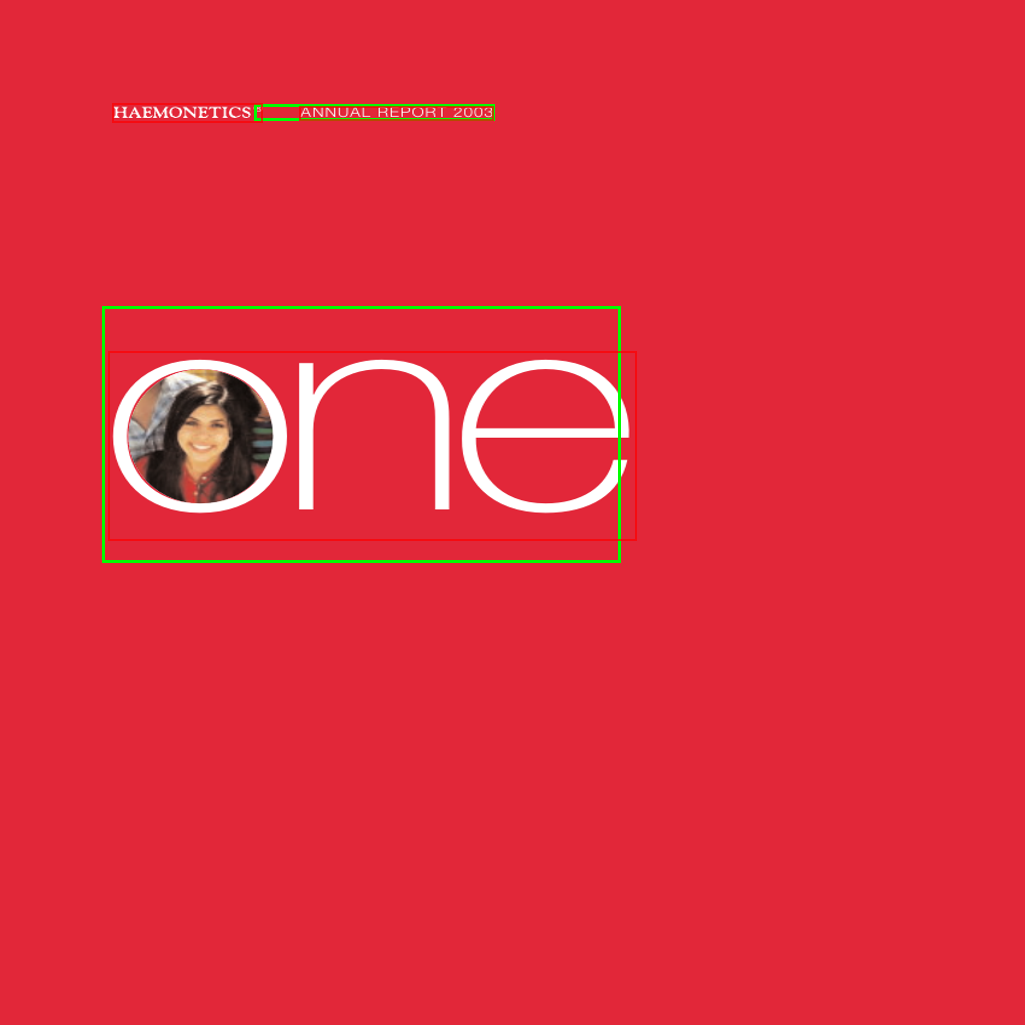

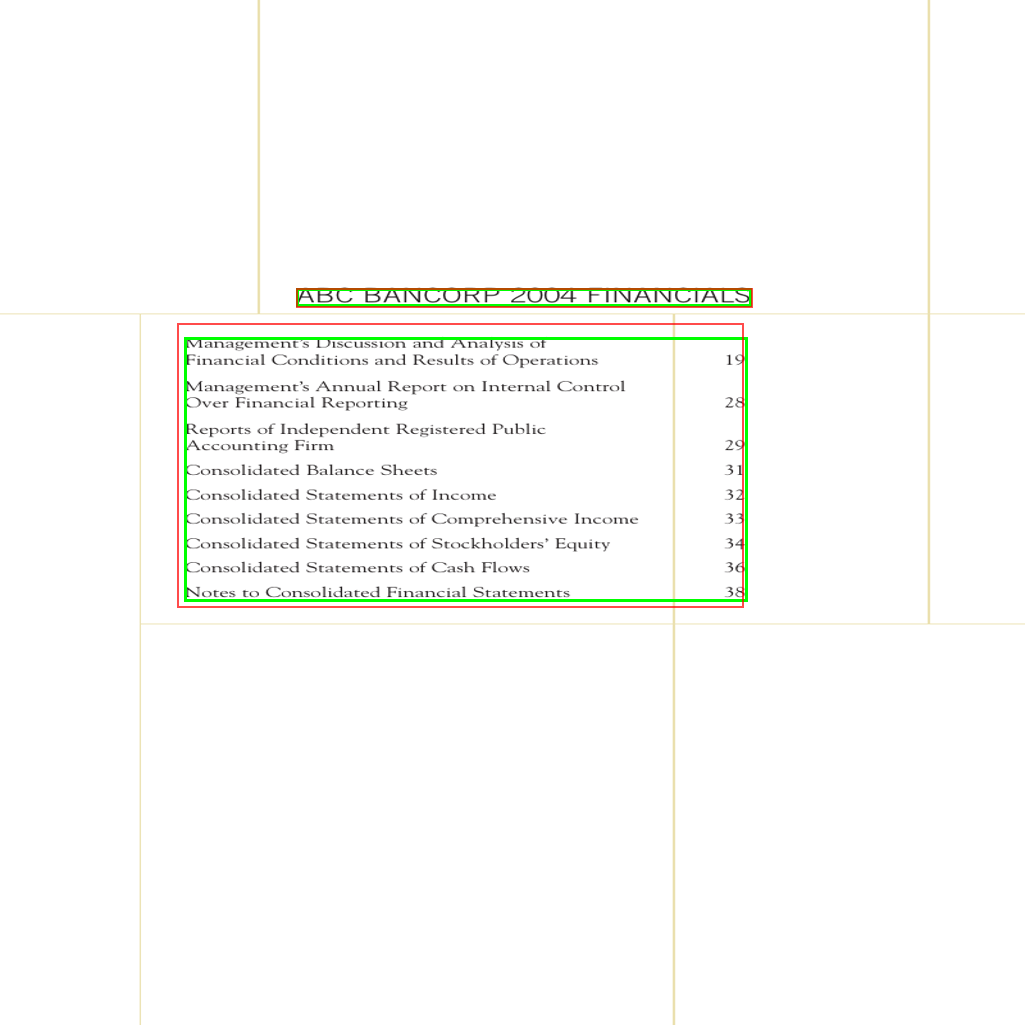


== Samples for FOOTNOTE (cid=2) ==


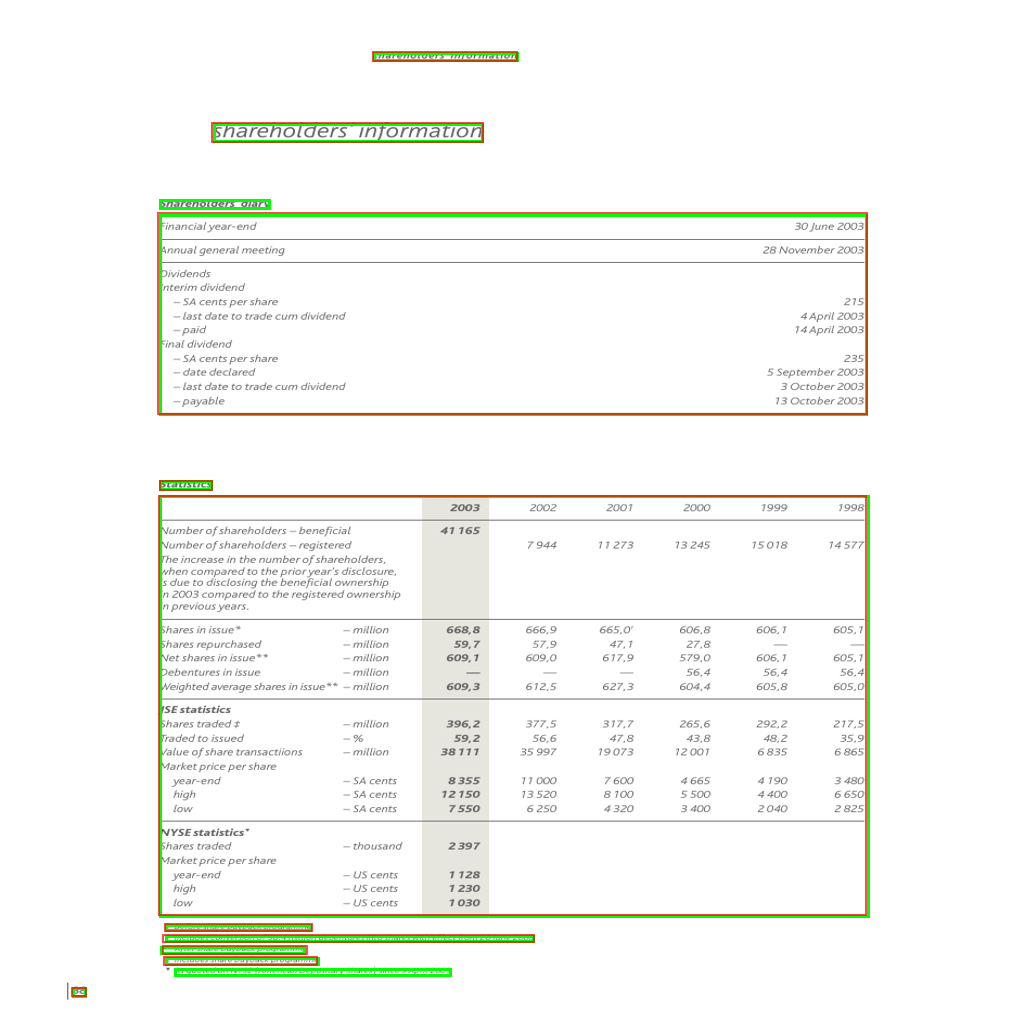


== Samples for FORMULA (cid=3) ==


In [15]:
import random
from PIL import Image, ImageDraw

def sample_images_with_class(cid, k=3):
    ids = []
    for ann in coco_gt.dataset["annotations"]:
        if ann["category_id"] == cid and ann["image_id"] in allowed_img_ids:
            ids.append(ann["image_id"])
    return random.sample(list(set(ids)), min(k, len(set(ids))))

def show_image_with_gt_and_preds(iid):
    img_info = coco_gt.loadImgs([iid])[0]
    p1 = IMGDIR / img_info["file_name"]
    p2 = IMGDIR / f"{iid}.png"
    path = p1 if p1.exists() else p2
    im = Image.open(path).convert("RGB")
    dr = ImageDraw.Draw(im, "RGBA")

    # draw GT (green)
    for ann in coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[iid])):
        x,y,w,h = ann["bbox"]
        dr.rectangle([x,y,x+w,y+h], outline=(0,255,0,255), width=3)

    # draw preds (red)
    with open(OUT / "COCO" / "pred_val.json") as f:
        preds = json.load(f)
    for d in preds:
        if d["image_id"] == iid:
            x,y,w,h = d["bbox"]
            dr.rectangle([x,y,x+w,y+h], outline=(255,0,0,180), width=2)

    display(im)

# Example: look at TITLE (cid=11) and FOOTNOTE (cid=2)
for cid in [11, 2, 3]:
    print(f"\n== Samples for {cats.get(cid, cid)} (cid={cid}) ==")
    for iid in sample_images_with_class(cid, k=2):
        show_image_with_gt_and_preds(iid)

In [16]:
import numpy as np

def size_category(area):
    if area < 32**2: return "small"
    if area < 96**2: return "medium"
    return "large"

# check size distribution for PICTURE (cat_id = 7)
sizes = {"small":0,"medium":0,"large":0}
for ann in coco_gt.dataset["annotations"]:
    if ann["category_id"] == 7:  # picture
        sizes[size_category(ann["area"])] += 1

print("PICTURE size distribution:", sizes)

PICTURE size distribution: {'small': 0, 'medium': 20, 'large': 156}


In [17]:
import numpy as np

def size_category(area):
    if area < 32**2:
        return "small"
    if area < 96**2:
        return "medium"
    return "large"

# check size distribution for CAPTION (cat_id = 1)
sizes = {"small": 0, "medium": 0, "large": 0}
for ann in coco_gt.dataset["annotations"]:
    if ann["category_id"] == 1:  # CAPTION
        sizes[size_category(ann["area"])] += 1

print("CAPTION size distribution:", sizes)

CAPTION size distribution: {'small': 1, 'medium': 50, 'large': 2}
